In [10]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

# Get and Load the Pima Indians Diabetes dataset

We download the data from an nrvis repository. And we load it into a pandas dataframe.

In [11]:
!wget http://nrvis.com/data/mldata/pima-indians-diabetes.csv

--2021-01-11 22:49:27--  http://nrvis.com/data/mldata/pima-indians-diabetes.csv
Resolving nrvis.com (nrvis.com)... 173.236.176.48
Connecting to nrvis.com (nrvis.com)|173.236.176.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23279 (23K) [text/csv]
Saving to: ‘pima-indians-diabetes.csv.1’

pima-indians-diabet 100%[===================>]  22.73K  --.-KB/s    in 0.02s   

2021-01-11 22:49:27 (1.15 MB/s) - ‘pima-indians-diabetes.csv.1’ saved [23279/23279]



In [12]:
df = pd.read_csv('pima-indians-diabetes.csv',header=None)
# 0. Number of times pregnant
# 1. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
# 2. Diastolic blood pressure (mm Hg)
# 3. Triceps skin fold thickness (mm)
# 4. 2-Hour serum insulin (mu U/ml)
# 5. Body mass index (weight in kg/(height in m)^2)
# 6. Diabetes pedigree function
# 7. Age (years)
# 8. Class variable (0 or 1)
df.columns = ["NumTimesPrg", "PlGlcConc", "BloodP", "SkinThick", "TwoHourSerIns", "BMI", "DiPedFunc", "Age", "HasDiabetes"]

--------------------------------------------------------------------

# Define Helper Functions

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, roc_auc_score
import statsmodels.api as sm

### Train using a Logistic Regression

We use a simple Logistic Regression model to train our datasets

In [14]:
def train_lr(df_train):
  X = df_train.iloc[:,range(8)]
  Y = df_train.iloc[:,8]

  X = sm.add_constant(X)

  model = sm.Logit(Y, X).fit()

  print(model.summary())

  return model

#### Predict and generate accuracry score

We use our model to generate prediction probabilites (range 0-1) on our test dataset. We use prediction probability >= 0.5 to assess if the model predicts the individual has diabetes.

We then compare if the individual actually had diabetes and generate an accurancy for our model.

In [15]:
def predict_and_evaluate(df_test, model):
  y_pred = model.predict(sm.add_constant(df_test.iloc[:,range(8)]))
  y_pred.name='prediction'
  res = pd.concat([df_test, y_pred],axis=1)

  res['PredDiabetes'] = np.where(res['prediction'] >= 0.5, 1, 0)

  acc = accuracy_score(res['HasDiabetes'], res['PredDiabetes'])
  print('\n')
  print(f'Accuracy = {acc}')

  print(classification_report(res['HasDiabetes'], res['PredDiabetes']))

  roc_auc = roc_auc_score(res['HasDiabetes'], res['prediction'])
  print(f'ROC AUC = {roc_auc}')

  return res

#### Plot top-k confident and correct/incorrect

We create side-by-side plots of the top-k samples where the model was confident in its prediction, with the first plot being most confident yet incorrect prediction and the second being the most confident and correct prediction.

Such plots can be used to analyze which variables might be leading the model astray in extreme situations.

In [16]:
def plot_topk(res, k=5):
  fig, ax = plt.subplots(1,2,figsize=(10,6))
  ((res.loc[res['HasDiabetes']==0].sort_values('prediction',ascending=False).head(k) - res.mean())/res.std()).iloc[:,range(8)].plot.bar(ax=ax[0],legend=False,title='confident and incorrect')
  ((res.loc[res['HasDiabetes']==1].sort_values('prediction',ascending=False).head(k) - res.mean())/res.std()).iloc[:,range(8)].plot.bar(ax=ax[1],title='confident and correct')
  plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
  plt.show()

--------------------------------------------------------------------

# Baseline

We train a baseline LR model and test without any popuation straifications

Optimization terminated successfully.
         Current function value: 0.483040
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            HasDiabetes   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Mon, 11 Jan 2021   Pseudo R-squ.:                  0.2607
Time:                        22:49:50   Log-Likelihood:                -296.59
converged:                       True   LL-Null:                       -401.18
Covariance Type:            nonrobust   LLR p-value:                 7.418e-41
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -8.1937      0.780    -10.507      0.000      -9.722      -6.665
NumTimesPrg       0.

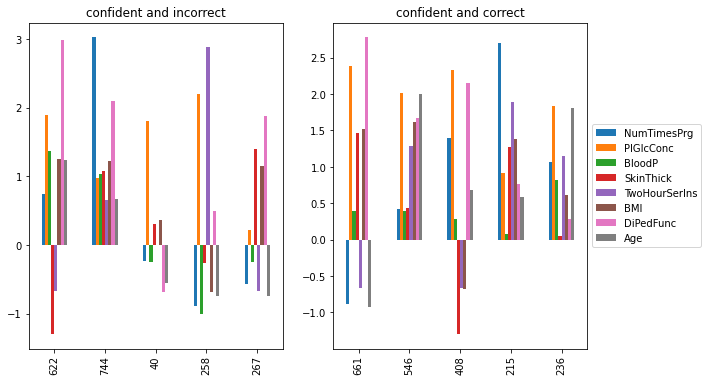

In [19]:
df_train, df_test = train_test_split(df,test_size=0.2, random_state=0)
model = train_lr(df_train)

res = predict_and_evaluate(df_test, model)
plot_topk(res)

We find our simple Logistic Regression model performs decently well at predicting diabetes among the full population

--------------------------------------------------------------------

# Straification on Subpopulations

Now we test the model on different population stratifications. We choose 4 subpopulations based on younger/older age and never/have been pregnant:

1 - Younger (Age < 30) and never been pregnant (NumTimesPrg == 0)

2 - Younger (Age < 30) and have been pregnant (NumTimesPrg >= 1)

3 - Older only (Age >= 65)

4 - Mid-Older (Age > 45) and never been pregnant (NumTimesPrg == 0)

Subpopulation 4 was intentionally chosen to produce bad model evaluation metrics.

In [230]:
# Good population stratifications
df_test_strat1 = df[(df['Age'] < 30) & (df['NumTimesPrg'] == 0)]
df_test_strat2 = df[(df['Age'] < 30) & (df['NumTimesPrg'] >= 1)]
df_test_strat3 = df[(df['Age'] >= 65)]
# Bad population stratifications
df_test_strat4 = df[(df['Age'] > 45) & (df['NumTimesPrg'] == 0)]

# Stratification #1



Accuracy = 0.8390804597701149
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        61
           1       0.80      0.62      0.70        26

    accuracy                           0.84        87
   macro avg       0.83      0.77      0.79        87
weighted avg       0.84      0.84      0.83        87

ROC AUC = 0.907313997477932


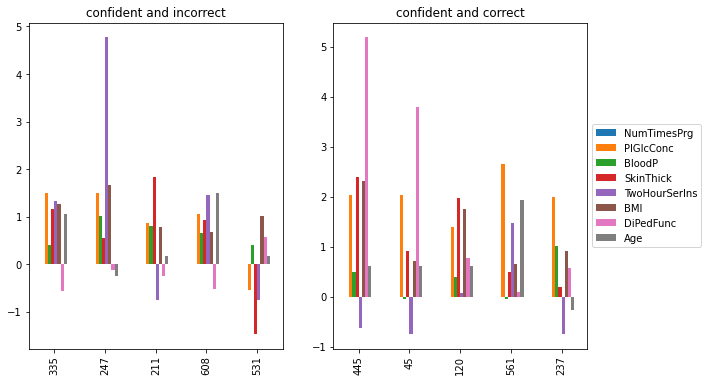

In [231]:
res = predict_and_evaluate(df_test_strat1, model)
plot_topk(res)

# Stratification #2



Accuracy = 0.86084142394822
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       251
           1       0.68      0.48      0.57        58

    accuracy                           0.86       309
   macro avg       0.79      0.72      0.74       309
weighted avg       0.85      0.86      0.85       309

ROC AUC = 0.8607638411869762


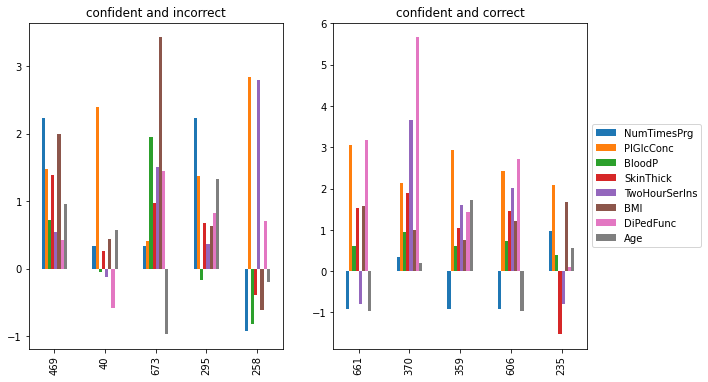

In [226]:
res = predict_and_evaluate(df_test_strat2, model)
plot_topk(res)

# Stratification #3



Accuracy = 0.6875
              precision    recall  f1-score   support

           0       1.00      0.58      0.74        12
           1       0.44      1.00      0.62         4

    accuracy                           0.69        16
   macro avg       0.72      0.79      0.68        16
weighted avg       0.86      0.69      0.71        16

ROC AUC = 0.8750000000000001


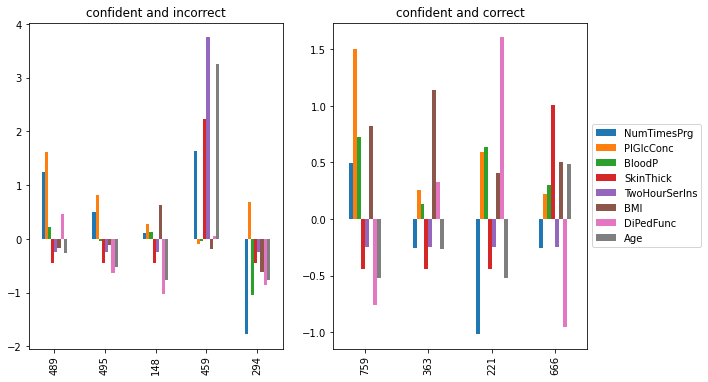

In [227]:
res = predict_and_evaluate(df_test_strat3, model)
plot_topk(res)

# Analysis of good stratifications

We see from these examples that each chosen stratification generates Logistic Regression models that perform fairly well (~70% to 85% accuracy) and high Receiver Operating Characteristic Area Under Curve (ROC AUC). 

The bar-plots indicate that certain features are good performers in pushing the model towards the correct prediction (PlGlcConc, BMI). DiPedFunc (a value related to pedigree) is very important in correct predictions for younger subpopulations, but this effect starts to diminish for older subpopulations.

These results indicate that population stratifications of interesting features allows the model to have similar to better test performance on models trained on the whole population.

--------------------------------------------------------------------

# Analysis of bad stratifications

Now we evaluate on the fourth stratification, which was intentionally chosen to produce poor results



Accuracy = 0.5
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.00      0.00      0.00         2

    accuracy                           0.50         8
   macro avg       0.33      0.33      0.33         8
weighted avg       0.50      0.50      0.50         8

ROC AUC = 0.5833333333333334


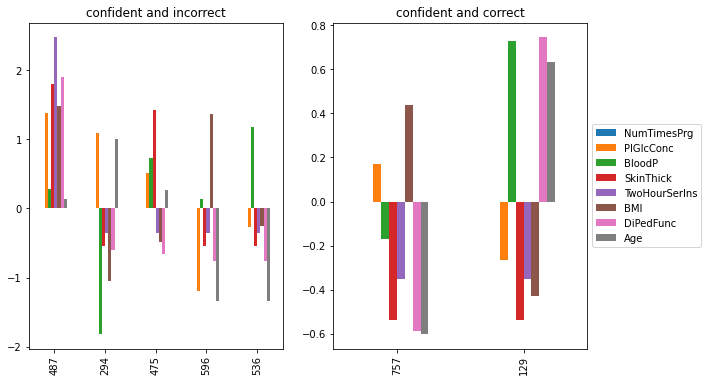

In [233]:
res = predict_and_evaluate(df_test_strat4, model)
plot_topk(res)

We see that the trained model does not perform well, with an accuracy similar to random unweighted chance. In this subpopulation, there is greater disparity in which features helped produce the correct outcomes.

# Summary

| Model | Accuracy | Precision | Recall | F1 score | ROC AUC |
| :----:| :------: | :-------: | :-----:| :-------:| :-----: |
|  Baseline   |  0.82   |   0.82   |  0.82  |   0.82   |   0.87  |
|  Strat 1   |   0.84  |   0.84   |  0.84  |   0.83   |   0.91  |
|  Strat 2 |   0.86 |   0.85  |  0.86  |  0.85    |   0.86  |
|  Strat 3 |  0.69    |  0.86  | 0.69  |  0.71  |  0.88 |
|  Strat 4 |  0.50    |  0.50  | 0.50  |  0.50  |  0.58 |

#### Exercise for the Reader: Training with stratified populations
As a followup exercise for the reader, a similar analysis can be done with models that are trained on the stratified populations (and evaluated on subpopulations of other features).

# Conclusion

In this notebook we see that using trained models to evaluate on certain subpopulaions can be both advantageous and disadvantageous. It demonstrates the importance of understanding these subpopulations and how the model might be affected, as well as evaluating these test cases before launching the model into the real world setting. 